In [45]:
#import required libraries
import numpy as np
import pandas as pd
from pandas import DataFrame 
import matplotlib.pyplot as plt
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [4]:
#read the json file
df = pd.read_json("C:/Users/sandhya.mukkamala/Downloads/Clothing_Shoes_and_Jewelry_5.json", lines=True)

In [5]:
#convert the json file to csv for easy access of data
df.to_csv('reviews.csv', sep=',', index = False)

In [6]:
#save the converted data into a csv file and check the data
df = pd.read_csv('reviews.csv')
print(df.columns)
print(df.shape)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')
(278677, 9)


In [7]:
#Copy the dataframe so we dont loose any data even if we make changes in future
df_copy = df.copy()

In [8]:
print(sum(df.reviewerID.duplicated()))
purchase_ids = ['reviewerID','asin']
duplicates = df[df.duplicated(subset=purchase_ids,
                                        keep=False)].sort_values(purchase_ids)

239290


Though it seems there are many duplicates, there are no replated reviews each review is unique for different products by a customer.

In [9]:
df.isnull().sum()

reviewerID          0
asin                0
reviewerName      469
helpful             0
reviewText         24
overall             0
summary             1
unixReviewTime      0
reviewTime          0
dtype: int64

As seen only reviewText and sumary has missing values which are 24 and 1 respectively. As summary can be considered as minimal version of reviewtext. we can ignore the reviewText as we will be dropping the column going forward. And, summary has only 1 missing value which can be ingnored.

In [10]:
columns = ['reviewerName','helpful','unixReviewTime','reviewTime']
df.drop(columns, axis=1, inplace=True)

change the cloumn names for better understanding

In [11]:
#Let's count how many total reviews are given for each product and sort the dataframe accordingly to later make selections
reviewer_count = df.groupby("asin", as_index=False).count()

#create a new df with the count data merged in to actual df for further analysis
df_merged = pd.merge(df, reviewer_count, how='right', on=['asin'])
df_merged

,reviewerID_x,asin,reviewText_x,overall_x,summary_x,reviewerID_y,reviewText_y,overall_y,summary_y
0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,23,23,23,23
1,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,23,23,23,23
2,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...,5,I have buy more than one,23,23,23,23
3,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",23,23,23,23
4,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,23,23,23,23
...,...,...,...,...,...,...,...,...,...
278672,A2DG63DN704LOI,B00KKXCJQU,I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,9,9,9,9
278673,A1EVV74UQYVKRY,B00KKXCJQU,I've been traveling back and forth to England ...,5,Wonderful for Better Packing,9,9,9,9
278674,A1UQBFCERIP7VJ,B00KKXCJQU,These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",9,9,9,9
278675,A22CW0ZHY3NJH8,B00KKXCJQU,I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,9,9,9,9


In [12]:
#rename columns
df_merged["productID"] = df_merged["asin"]
df_merged["total_reviewers"] = df_merged["reviewerID_y"]
df_merged["overall_rating"] = df_merged["overall_x"]
df_merged["review_summary"] = df_merged["summary_x"]

In [13]:
df_new = df_merged[['productID','review_summary','overall_rating',"total_reviewers"]]
df_new.head(3)

,productID,review_summary,overall_rating,total_reviewers
0,0000031887,Great tutu- not cheaply made,5,23
1,0000031887,Very Cute!!,5,23
2,0000031887,I have buy more than one,5,23


In [14]:
#Selecting products which have more than 100 reviews
df_new = df_new.sort_values(by='total_reviewers', ascending=False)
df_new = df_new[df_merged.total_reviewers >= 100]
df_new

C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,productID,review_summary,overall_rating,total_reviewers
161700,B005LERHD8,It's ok,4,441
161269,B005LERHD8,Really Cute,4,441
161280,B005LERHD8,Very pretty,4,441
161279,B005LERHD8,Not worth your money,1,441
161278,B005LERHD8,Really pretty!,5,441
...,...,...,...,...
114084,B003YBHF82,"cute, but not good for my feet",2,100
114083,B003YBHF82,Crocs Sandal,5,100
114082,B003YBHF82,Minimal Yet Comfortable,5,100
114081,B003YBHF82,Excellent,5,100


It can be observed that we have reduced the data to 13379 rows, which is easy to handle and also enough to make recommendations.

In [15]:
#grouping all the summary Reviews by product ID
df_productReview = df_new.groupby("productID", as_index=False).mean()
ProductReviewSummary = df_new.groupby('productID')["review_summary"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [16]:
df1 = pd.read_csv("ProductReviewSummary.csv")
df_ProductReview = pd.merge(df1, df_productReview, on='productID', how='inner')

## Text Cleaning

In [17]:
# Text Cleaning - review_summary Column
#function for tokenizing reviews
regEx = re.compile('[^a-z]+')
def cleanReviews(review_Text):
    review_Text = review_Text.lower()
    review_Text = regEx.sub(' ', review_Text).strip()
    return review_Text

In [18]:
#reset index and drop duplicate rows
df_ProductReview["clean_summary"] = df_ProductReview["review_summary"].apply(cleanReviews)
df_ProductReview = df_ProductReview.drop_duplicates(['overall_rating'], keep='last')
df_ProductReview = df_ProductReview.reset_index()

In [19]:
reviews = df_ProductReview["clean_summary"] 
count_vector = CountVectorizer(max_features = 300, stop_words='english') 
transformed_reviews = count_vector.fit_transform(reviews) 

df_Reviews = DataFrame(transformed_reviews.A, columns=count_vector.get_feature_names())
df_Reviews = df_Reviews.astype(int)

In [20]:
#save
df_Reviews.to_csv("df_Reviews.csv")

In [21]:
# First let's create a dataset called X
X = np.array(df_Reviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(df_Reviews)))
df_Reviews_train = X[:tsize]
df_Reviews_test = X[tsize:]
#len of train and test
lentrain = len(df_Reviews_train)
lentest = len(df_Reviews_test)

In [22]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

80
9


## kNN with k = 3, Algorithm = ball_tree

In [23]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df_Reviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(df_Reviews_train)

In [24]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([df_Reviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df_productReview["productID"][lentrain + i] ," average rating is ",df_productReview["overall_rating"][lentrain + i])
    print ("The first similar product is ", df_productReview["productID"][first_related_product] ," average rating is ",df_productReview["overall_rating"][first_related_product])
    print ("The second similar product is ", df_productReview["productID"][second_related_product] ," average rating is ",df_productReview["overall_rating"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B008X0EW44  average rating is  3.874125874125874
The first similar product is  B004Q7AB4I  average rating is  4.337142857142857
The second similar product is  B004Z1CZDK  average rating is  3.1923076923076925
-----------------------------------------------------------
Based on product reviews, for  B009DNWFD0  average rating is  3.8446601941747574
The first similar product is  B003YBHF82  average rating is  4.21
The second similar product is  B007NLX16O  average rating is  4.507936507936508
-----------------------------------------------------------
Based on product reviews, for  B009ZDEXQK  average rating is  4.7254901960784315
The first similar product is  B003YBHF82  average rating is  4.21
The second similar product is  B0068VM5T4  average rating is  4.58955223880597
-----------------------------------------------------------
Based on product reviews, for  B00BNB3A0W  average rating is  3.4414414414414414
The first similar product is  B007RD9DS8  aver

In [25]:
print ("Based on product reviews, for ", df_ProductReview["productID"][50] ," average rating is ",df_ProductReview["overall_rating"][50])
print ("The first similar product is ", df_ProductReview["productID"][first_related_product] ," average rating is ",df_ProductReview["overall_rating"][first_related_product])
print ("The second similar product is ", df_ProductReview["productID"][second_related_product] ," average rating is ",df_ProductReview["overall_rating"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B0051U15E4  average rating is  4.412280701754386
The first similar product is  B003YBHF82  average rating is  4.21
The second similar product is  B000FH4JJQ  average rating is  4.536363636363636
-----------------------------------------------------------


## Predicting Review Score with k = 3

In [26]:
df_train_target = df_ProductReview["overall_rating"][:lentrain]
df_test_target = df_ProductReview["overall_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df_Reviews_train, df_train_target)
knnpreds_test = knnclf.predict(df_Reviews_test)

print(classification_report(df_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



## Accuracy of the model

In [27]:
print (accuracy_score(df_test_target, knnpreds_test))

1.0


In [28]:
print(mean_squared_error(df_test_target, knnpreds_test))

0.0


## Predicting Review Score with k = 10

In [29]:
df_train_target = df_ProductReview["overall_rating"][:lentrain]
df_test_target = df_ProductReview["overall_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)

n_neighbors = 10
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df_Reviews_train, df_train_target)
knnpreds_test = knnclf.predict(df_Reviews_test)

print(classification_report(df_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.33      0.50         3
           4       0.75      1.00      0.86         6

    accuracy                           0.78         9
   macro avg       0.88      0.67      0.68         9
weighted avg       0.83      0.78      0.74         9



In [30]:
print (accuracy_score(df_test_target, knnpreds_test))

0.7777777777777778


In [31]:
print(mean_squared_error(df_test_target, knnpreds_test))

0.2222222222222222


## Predicting reviews with 85, 15 train, test split and k = 5

In [32]:
# First let's create a dataset called X
X = np.array(df_Reviews)
 # create train and test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(df_Reviews)))
df_Reviews_train = X[:tsize]
df_Reviews_test = X[tsize:]
#len of train and test
lentrain = len(df_Reviews_train)
lentest = len(df_Reviews_test)

In [33]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
neighbor = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(df_Reviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(df_Reviews_train)

In [34]:
#find most related products
for i in range(lentest):
    a = neighbor.kneighbors([df_Reviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df_ProductReview["productID"][lentrain + i] ," average rating is ",df_ProductReview["overall_rating"][lentrain + i])
    print ("The first similar product is ", df_ProductReview["productID"][first_related_product] ," average rating is ",df_ProductReview["overall_rating"][first_related_product])
    print ("The second similar product is ", df_ProductReview["productID"][second_related_product] ," average rating is ",df_ProductReview["overall_rating"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B008RUOCJU  average rating is  3.973684210526316
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B004R1II48  average rating is  4.055555555555555
-----------------------------------------------------------
Based on product reviews, for  B008WYDP1C  average rating is  4.257028112449799
The first similar product is  B007WA3K4Y  average rating is  4.209424083769633
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B008X0EW44  average rating is  3.874125874125874
The first similar product is  B007WAEBPQ  average rating is  4.333333333333333
The second similar product is  B0083S18LQ  average rating is  3.9565217391304346
-----------------------------------------------------------
Based on product reviews, for  B009DNWFD0  average rating is  3.8446601941747574
The first similar pr

## Predicting Review Score with k = 3

In [35]:
df_train_target = df_ProductReview["overall_rating"][:lentrain]
df_test_target = df_ProductReview["overall_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df_Reviews_train, df_train_target)
knnpreds_test = knnclf.predict(df_Reviews_test)

print(classification_report(df_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.67      0.80         6
           4       0.80      1.00      0.89         8

    accuracy                           0.86        14
   macro avg       0.90      0.83      0.84        14
weighted avg       0.89      0.86      0.85        14



In [36]:
print (accuracy_score(df_test_target, knnpreds_test))

0.8571428571428571


In [37]:
print(mean_squared_error(df_test_target, knnpreds_test))

0.14285714285714285


## kNN with k = 3, Algorithm = Brute

In [38]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(df_Reviews_train)

distances, indices = neighbor.kneighbors(df_Reviews_train)

In [39]:
df_train_target = df_ProductReview["overall_rating"][:lentrain]
df_test_target = df_ProductReview["overall_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df_Reviews_train, df_train_target)
knnpreds_test = knnclf.predict(df_Reviews_test)

print(classification_report(df_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       1.00      0.67      0.80         6
           4       0.80      1.00      0.89         8

    accuracy                           0.86        14
   macro avg       0.90      0.83      0.84        14
weighted avg       0.89      0.86      0.85        14

Accuracy:  0.8571428571428571
MSE:  0.14285714285714285


## kNN with k= 8, and Algorithm = KD_Tree

In [40]:
neighbor = NearestNeighbors(n_neighbors=8, algorithm='kd_tree').fit(df_Reviews_train)
distances, indices = neighbor.kneighbors(df_Reviews_train)

In [41]:
df_train_target = df_ProductReview["overall_rating"][:lentrain]
df_test_target = df_ProductReview["overall_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df_Reviews_train, df_train_target)
knnpreds_test = knnclf.predict(df_Reviews_test)

print(classification_report(df_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         6
           4       0.57      1.00      0.73         8

    accuracy                           0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14

Accuracy:  0.5714285714285714
MSE:  0.42857142857142855


C:\Users\sandhya.mukkamala\PycharmProjects\Conda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


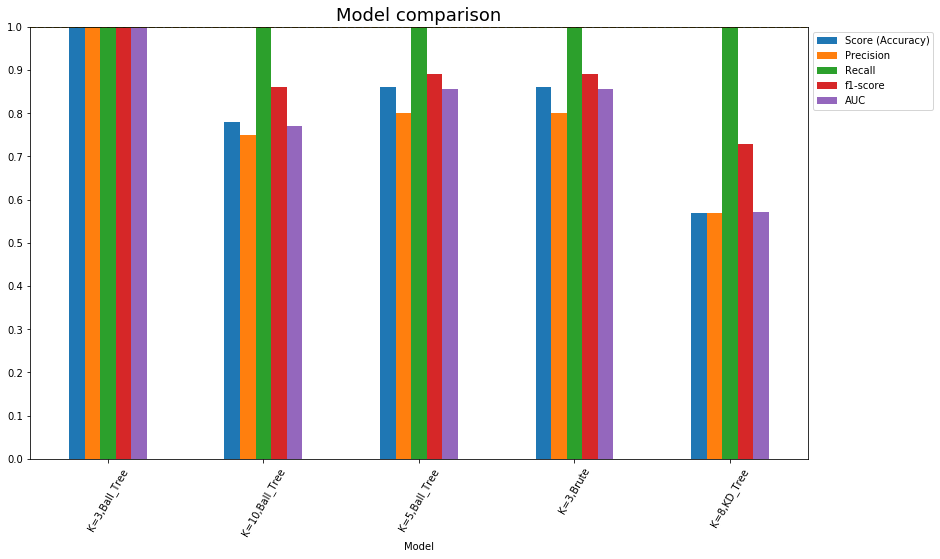

In [46]:
# individual results
K_3_bt = np.array([1.00, 1.00, 1.00, 1.00, 1.00])
k_10_bt = np.array([0.78, 0.75, 1.00, 0.86, 0.77])
k_5_bt = np.array([0.86, 0.80, 1.00, 0.89, 0.857])
K_3_br = np.array([0.86, 0.80, 1.00, 0.89, 0.857])
K_8_Tr = np.array([0.57, 0.57, 1.00, 0.73, 0.571])

r_columns = ['Score (Accuracy)', 'Precision', 'Recall', 'f1-score', 'AUC']
r_index = ['K=3,Ball_Tree', 'K=10,Ball_Tree', 'K=5,Ball_Tree', 'K=3,Brute', 'K=8,KD_Tree']

results = pd.DataFrame(np.row_stack([K_3_bt, k_10_bt, k_5_bt, K_3_br, K_8_Tr]), 
                       index=r_index, columns=r_columns)

# plot
results.plot(kind='bar')

# formatting
plt.title("Model comparison", fontsize=18)
plt.xlabel("Model")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axhline(y=np.max(results['AUC']), c='green', linestyle='--')
plt.axhline(y=np.max(results[['Score (Accuracy)', 'Precision', 'Recall', 'f1-score']]).max(), c='orange', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=60)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.8, top=1, wspace=0, hspace=0)
plt.show()